In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot

import re
import sklearn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv('h1b dataset.csv')

In [3]:
df.drop(['Unnamed: 0'],inplace = True,axis = 1)
df.head()

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CASE_STATUS         object 
 1   EMPLOYER_NAME       object 
 2   SOC_NAME            object 
 3   JOB_TITLE           object 
 4   FULL_TIME_POSITION  object 
 5   PREVAILING_WAGE     float64
 6   YEAR                float64
 7   WORKSITE            object 
 8   lon                 float64
 9   lat                 float64
dtypes: float64(4), object(6)
memory usage: 229.1+ MB


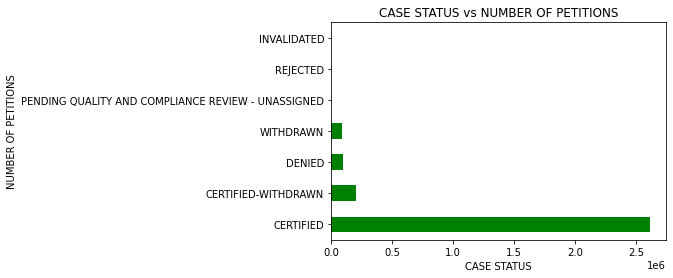

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64


In [5]:
##Before training models, I tried to decide which major labels to focus on

plot_status_numberinit = df['CASE_STATUS'].value_counts().plot(title = 'CASE STATUS vs NUMBER OF PETITIONS', \
                                                                kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("CASE STATUS")
plot_status_numberinit.set_ylabel("NUMBER OF PETITIONS")
plt.show()
print(df['CASE_STATUS'].value_counts())

Computer Systems Analysts                    291170
Computer Programmers                         226574
SOFTWARE DEVELOPERS, APPLICATIONS            221783
COMPUTER SYSTEMS ANALYSTS                    215353
Software Developers, Applications            192933
COMPUTER PROGRAMMERS                         171972
COMPUTER OCCUPATIONS, ALL OTHER              108555
Computer Occupations, All Other               69315
Software Developers, Systems Software         44500
SOFTWARE DEVELOPERS, SYSTEMS SOFTWARE         39356
Management Analysts                           38756
Financial Analysts                            34141
Computer Software Engineers, Applications     33325
Accountants and Auditors                      30708
MANAGEMENT ANALYSTS                           28117
Name: SOC_NAME, dtype: int64


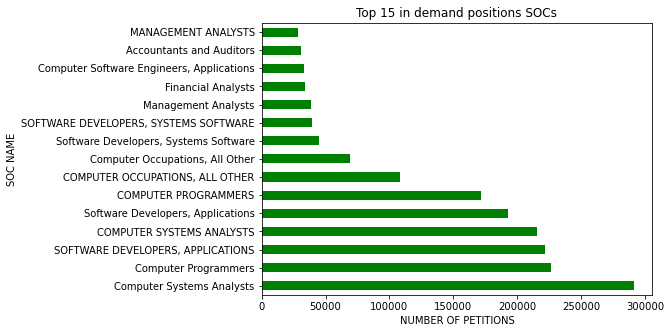

In [6]:
plot_status_topsoc= df['SOC_NAME'].value_counts().head(15).plot.barh(title = "Top 15 in demand positions SOCs", \
                                                                 color = 'green', figsize = (7, 5))
plot_status_topsoc.set_ylabel("SOC NAME")
plot_status_topsoc.set_xlabel("NUMBER OF PETITIONS")
plot_status_topsoc
print(df['SOC_NAME'].value_counts().head(15))

In [7]:
### drop other categories, only keep denied, certified and certified_withdrawn (combine the last two)

df["CASE_STATUS"].unique()

array(['CERTIFIED-WITHDRAWN', 'WITHDRAWN', 'CERTIFIED', 'DENIED',
       'REJECTED', 'INVALIDATED',
       'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED', nan],
      dtype=object)

In [8]:
# df[df.CASE_STATUS != 'REJECTED']

In [9]:
idx_drop1 = df[df.CASE_STATUS == 'REJECTED'].index
df.drop(idx_drop1, inplace = True)

In [10]:
idx_drop2 = df[df.CASE_STATUS == 'WITHDRAWN'].index
df.drop(idx_drop2, inplace = True)

In [11]:
idx_d3 = df[df.CASE_STATUS == 'INVALIDATED'].index
df.drop(idx_d3, inplace = True)

In [12]:
idx_d4 = df[df.CASE_STATUS == 'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'].index
df.drop(idx_d4, inplace = True)

In [13]:
df = df.replace(to_replace = 'CERTIFIED-WITHDRAWN', value = 'CERTIFIED', regex = True)

In [14]:
df["CASE_STATUS"].unique()

array(['CERTIFIED', 'DENIED', nan], dtype=object)

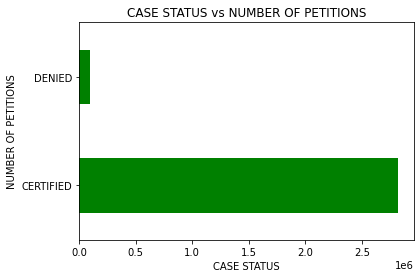

CERTIFIED    2818282
DENIED         94346
Name: CASE_STATUS, dtype: int64


In [15]:
plot_status_numberinit = df['CASE_STATUS'].value_counts().plot(title = 'CASE STATUS vs NUMBER OF PETITIONS', \
                                                                kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("CASE STATUS")
plot_status_numberinit.set_ylabel("NUMBER OF PETITIONS")
plt.show()
print(df['CASE_STATUS'].value_counts())

In [16]:
df.isnull().sum().sort_values(ascending = False)

lon                   102843
lat                   102843
SOC_NAME               17086
PREVAILING_WAGE           66
EMPLOYER_NAME             31
JOB_TITLE                 23
FULL_TIME_POSITION        14
CASE_STATUS               13
YEAR                      13
WORKSITE                   0
dtype: int64

In [17]:
df.nunique()

CASE_STATUS                2
EMPLOYER_NAME         234087
SOC_NAME                2108
JOB_TITLE             284547
FULL_TIME_POSITION         2
PREVAILING_WAGE        55654
YEAR                       6
WORKSITE               18189
lon                     2405
lat                     2407
dtype: int64

In [18]:
# Create the State column 
def state(data):
    states = []
    data_worksite = df['WORKSITE']

    for worksite in data_worksite.iloc[:]:
        state = worksite.split(', ')[1]
        states.append(state)
    return pd.DataFrame(states, columns=['State'])

states=state(df)
df['State']=states['State']

df['State'] = df.State.astype('category')
df['State'] = df.State.cat.codes

In [19]:
print(df.shape)                                          
df.dropna(subset=['CASE_STATUS', 'YEAR', 'FULL_TIME_POSITION', 'JOB_TITLE', 'EMPLOYER_NAME', 'PREVAILING_WAGE'], inplace=True)
print(df.shape)

(2912641, 11)
(2912547, 11)


In [20]:
# df['CASE_STATUS'] = df.CASE_STATUS.astype('category')
# df['CASE_STATUS'] = df.CASE_STATUS.cat.codes

In [21]:
dic_case_status = {'DENIED':0, "CERTIFIED": 1 } 
df['CASE_STATUS'] = df['CASE_STATUS'].apply(lambda x: dic_case_status[x])

In [22]:
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.upper()
top_emp = list(df['EMPLOYER_NAME'].groupby(df['EMPLOYER_NAME']).count().sort_values(ascending=False).head(1000).index)

df.loc[~df["EMPLOYER_NAME"].isin(top_emp), "EMPLOYER_NAME"] = "Others"
df['EMPLOYER_NAME'] = df.EMPLOYER_NAME.astype('category')
df['EMPLOYER_NAME'] = df.EMPLOYER_NAME.cat.codes

In [23]:
z = list(df['EMPLOYER_NAME'].groupby(df['EMPLOYER_NAME']).count().sort_values(ascending=False).head(1000))
z


[1502923,
 130317,
 64418,
 47497,
 36675,
 33316,
 30426,
 25128,
 22608,
 18220,
 16906,
 16458,
 16457,
 16104,
 12263,
 11877,
 10682,
 10649,
 9610,
 8694,
 7571,
 7205,
 6879,
 6632,
 6142,
 6048,
 5886,
 5257,
 5216,
 5205,
 5177,
 4589,
 4587,
 4385,
 4333,
 4292,
 4258,
 4168,
 4054,
 4010,
 3787,
 3674,
 3588,
 3582,
 3534,
 3509,
 3391,
 3378,
 3359,
 3314,
 3300,
 3252,
 3149,
 3140,
 3110,
 2974,
 2960,
 2922,
 2845,
 2839,
 2778,
 2748,
 2729,
 2711,
 2689,
 2632,
 2589,
 2575,
 2565,
 2552,
 2527,
 2521,
 2511,
 2495,
 2354,
 2350,
 2347,
 2325,
 2275,
 2258,
 2239,
 2211,
 2211,
 2203,
 2201,
 2195,
 2161,
 2139,
 2134,
 2065,
 2020,
 2008,
 2008,
 2007,
 1986,
 1985,
 1951,
 1931,
 1910,
 1905,
 1878,
 1859,
 1789,
 1779,
 1775,
 1773,
 1746,
 1725,
 1723,
 1710,
 1706,
 1706,
 1666,
 1638,
 1630,
 1620,
 1615,
 1614,
 1610,
 1608,
 1603,
 1601,
 1597,
 1586,
 1585,
 1584,
 1578,
 1576,
 1572,
 1554,
 1549,
 1541,
 1536,
 1514,
 1508,
 1502,
 1500,
 1486,
 1475,
 1453,

In [24]:
df['SOC_NAME'] = df['SOC_NAME'].str.upper()

df['SOC_NAME'] = df['SOC_NAME'].fillna(df['SOC_NAME'].mode()[0])

df['SOC_NAME1'] = 'others'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('computer','software')] = 'it'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('chief','management')] = 'manager'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('mechanical')] = 'mechanical'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('database')] = 'database'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('sales','market')] = 'scm'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('financial')] = 'finance'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('public','fundraising')] = 'pr'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('education','law')] = 'administrative'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('auditors','compliance')] = 'audit'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('distribution','logistics')] = 'scm'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('recruiters','human')] = 'hr'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('agricultural','farm')] = 'agri'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('construction','architectural')] = 'estate'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('forencsic','health')] = 'medical'
df['SOC_NAME1'][df['SOC_NAME'].str.contains('teachers')] = 'education'

df['SOC_NAME1'] = df.SOC_NAME1.astype('category')
df['SOC_NAME1'] = df.SOC_NAME1.cat.codes

In [25]:
df = df.drop(['JOB_TITLE'], axis = 1)

In [26]:
df['FULL_TIME_POSITION'] = df.FULL_TIME_POSITION.astype('category')
df['FULL_TIME_POSITION'] = df.FULL_TIME_POSITION.cat.codes

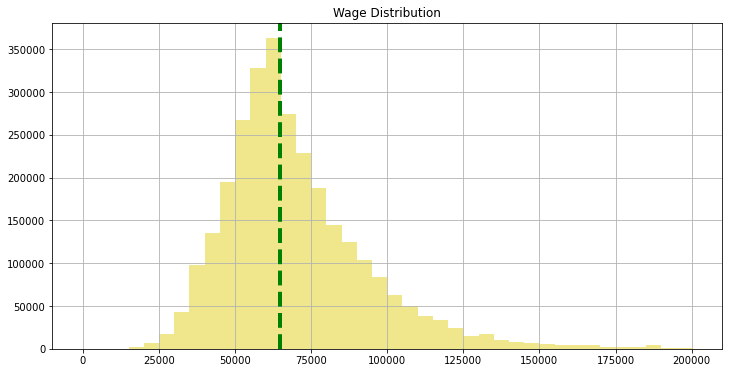

In [27]:
plt.figure(figsize=(12,6))
df[df['PREVAILING_WAGE']<200000].PREVAILING_WAGE.hist(bins=40,color='khaki')
plt.axvline(df[df['PREVAILING_WAGE']<=200000].PREVAILING_WAGE.median(), color='green', linestyle='dashed', linewidth=4)
plt.title('Wage Distribution')
plt.show()

In [28]:
df = df[df['PREVAILING_WAGE'] <= 200000]

In [29]:
df = df.drop(['lon','lat'], axis = 1)

In [30]:
df = df.drop(['SOC_NAME','WORKSITE'], axis = 1)

In [31]:
df.isnull().sum().sort_values(ascending = False)

CASE_STATUS           0
EMPLOYER_NAME         0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
State                 0
SOC_NAME1             0
dtype: int64

In [32]:
df.head()

,CASE_STATUS,EMPLOYER_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,State,SOC_NAME1
0,1,912,0,36067.0,2016.0,22,0
2,1,619,1,193066.0,2016.0,31,0
6,1,619,1,91021.0,2016.0,4,0
7,1,619,1,150000.0,2016.0,45,0
8,1,619,1,127546.0,2016.0,39,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2902527 entries, 0 to 3002392
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   CASE_STATUS         int64  
 1   EMPLOYER_NAME       int16  
 2   FULL_TIME_POSITION  int8   
 3   PREVAILING_WAGE     float64
 4   YEAR                float64
 5   State               int8   
 6   SOC_NAME1           int8   
dtypes: float64(2), int16(1), int64(1), int8(3)
memory usage: 102.4 MB


In [34]:
import matplotlib.pyplot as plt

# Import normalize
from sklearn.preprocessing import normalize

h1b = df.index

# Normalize the movements: normalized_movements
normalized_df = normalize(df)

# Import TSNE
from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))

<Figure size 2016x1656 with 0 Axes>

<Figure size 2016x1656 with 0 Axes>

In [35]:
from sklearn.manifold import TSNE
# Create a TSNE instance: model
model = TSNE(learning_rate=100)

In [ ]:
# Apply fit_transform to normalized_movements: tsne_features
tsne_den = model.fit_transform(normalized_df)

In [ ]:
# Select the 0th feature: xs
xs = tsne_df[:,0]

# Select the 1th feature: ys
ys = tsne_df[:,1]



In [ ]:
# Scatter plot
plt.scatter(xs, ys, alpha=0.5)
# Annotate the points
for x, y, aircraft in zip(xs, ys, h1b):
    plt.annotate(aircraft, (x, y), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# Import normalize
from sklearn.preprocessing import normalize

h1b = df.index

# Normalize the movements: normalized_movements
normalized_df = normalize(df)

# Import TSNE
from sklearn.manifold import TSNE

plt.figure(figsize=(28,23))

# Create a TSNE instance: model
model = TSNE(learning_rate=100)

# Apply fit_transform to normalized_movements: tsne_features
tsne_den = model.fit_transform(normalized_df)

# Select the 0th feature: xs
xs = tsne_df[:,0]

# Select the 1th feature: ys
ys = tsne_df[:,1]

# Scatter plot
plt.scatter(xs, ys, alpha=0.5)
# Annotate the points
for x, y, aircraft in zip(xs, ys, h1b):
    plt.annotate(aircraft, (x, y), fontsize=15, alpha=0.75)
#plt.figure(figsize=(18,20))
plt.show()


## EDA

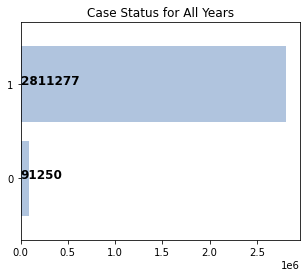

In [38]:
plt.figure(figsize=(5,4))

ax = df['CASE_STATUS'].value_counts().sort_values(ascending=True).plot.barh(width=0.8,color='lightsteelblue')
for i, v in enumerate(df['CASE_STATUS'].value_counts().sort_values(ascending=True).values): 
    ax.text(.6, i, v,fontsize=12,weight='bold')
plt.title('Case Status for All Years')
plt.show()

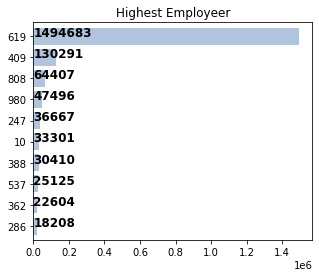

In [39]:
plt.figure(figsize=(5,4))

ax = df['EMPLOYER_NAME'].value_counts().sort_values(ascending=False)[:10].plot.barh(width=0.8,color='lightsteelblue')
for i, v in enumerate(df['EMPLOYER_NAME'].value_counts().sort_values(ascending=False).values[:10]): 
    ax.text(.6, i, v,fontsize=12,weight='bold')
plt.title('Highest Employeer')
fig = plt.gca()
fig.invert_yaxis()
plt.show()

In [40]:
comp_den=df[df['CASE_STATUS'].isin(['CERTIFIED','DENIED'])]
comp_den=comp_den[comp_den['EMPLOYER_NAME'].isin(comp_den['EMPLOYER_NAME'].value_counts().sort_values(ascending=False)[:10].index)]
comp_den=comp_den.groupby(['EMPLOYER_NAME','CASE_STATUS'])['JOB_TITLE'].count().reset_index()
comp_den=comp_den.pivot('EMPLOYER_NAME','CASE_STATUS','JOB_TITLE')
plt.figure(figsize=(25,10))
plt.scatter('CERTIFIED','DENIED',data=comp_den,s=comp_den['CERTIFIED']*0.03)
for i in range(comp_den.shape[0]):
    plt.text(comp_den['CERTIFIED'].values[i],comp_den['DENIED'].values[i],s=comp_den.index[i],color='black',weight='bold')
plt.title('Status Certified vs Denied',size=30)
plt.xlabel('CERTIFIED')
plt.ylabel('DENIED')
plt.show()

KeyError: 'Column not found: JOB_TITLE'

In [ ]:
plt.figure(figsize=(6,3))
df['YEAR'].value_counts().sort_values().plot(marker='o')
plt.title('H1B Applicants by Year')
plt.xlim([2010,2017])
plt.show()

In [ ]:
cer_den=df[df['CASE_STATUS'].isin(['CERTIFIED','DENIED'])]
cer_den=cer_den.groupby(['YEAR','CASE_STATUS'])['JOB_TITLE'].count().reset_index()
cer_den.pivot('YEAR','CASE_STATUS','JOB_TITLE').plot.bar(width=0.8)
fig=plt.gcf()
fig.set_size_inches(6,3)
plt.title('Case Status by Year')
plt.show()

In [ ]:
#Splitting data, model training and evaluation process

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

import os



new_df = pd.DataFrame()
new_df = df.copy()
new_df


new_df.head()

new_df.shape

new_df.info()

new_df = new_df.drop("CASE_STATUS", axis=1)

new_df["label"] = df["CASE_STATUS"]

new_df.head()






In [ ]:
#Split training and testing dataset

from sklearn.model_selection import train_test_split


y = new_df["label"]
x = new_df.iloc[:,0:5]

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    train_size=0.7, 
                                                    random_state=42)

print(f"Train labels:\n{y_train}")
print(f"Test labels:\n{y_test}")

df_a = x_train
df_b = y_train

training_data = pd.concat([df_a,df_b],axis = 1, join = "inner")

training_data

testing_data = pd.concat([x_test,y_test], axis = 1, join = "inner")

testing_data

# training_data.to_csv("C:/Users/liyug/Desktop/training data.csv", index = False)
# testing_data.to_csv("C:/Users/liyug/Desktop/final holdout data.csv", index = False)

In [ ]:
training_data["label"].unique()

In [ ]:
#reload training data

train_df=pd.read_csv('C:/Users/liyug/Desktop/dm final project/training data.csv')    
train_df.head()

train_df.shape

#new_train_df = train_df.copy()
nt_df = train_df.copy()

# split training and testing data in the training set for model training process
Y = nt_df["label"]
X = nt_df.iloc[:,0:5]

train_x, test_x, train_y, test_y = train_test_split(X, Y, 
                                                    train_size=0.7, 
                                                    random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
# Dealing with unbalanced dataset problem

oversample = SMOTE()
new_train_x, new_train_y = oversample.fit_resample(train_x, train_y)

plot_status_numberinit = new_train_y.value_counts().plot(title = 'CASE STATUS vs NUMBER OF PETITIONS', \
                                                                kind = 'barh', color = 'green')
plot_status_numberinit.set_xlabel("CASE STATUS")
plot_status_numberinit.set_ylabel("NUMBER OF PETITIONS")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.plot_roc_curve import plot_roc_curve

In [ ]:
#Training models

def fit_model (model):
    classifier = model()  #train with default model parameters
    classifier.fit(new_train_x, new_train_y)
    print("training accuracy is:",classifier.score(new_train_x, new_train_y))
    print("testing accuracy is:",classifier.score(test_x, test_y))   
    return classifier
    
# the fit_model function will return the mean accuracy of given test data and labels

# calculate precision, recall, fscore, and support score for the model
from sklearn.metrics import precision_recall_fscore_support

def prfs (trained_model):
    pred_label = trained_model.predict(test_x)
    print("When positive class refers to \"running\", the precision, recall, f_measure and support for the model is :",
          precision_recall_fscore_support(test_y, pred_label, average = "binary"))

    

def roc (clf.best_estimator_):
    plot_roc_curve(clf.best_estimator_, test_x, test_y)
    




In [ ]:
#SVC
svc = fit_model(SVC)




In [ ]:
#decision tree
dt = fit_model(DecisionTreeClassifier)




In [ ]:
#random forest
# rf = fit_model(RandomForestClassifier)
rf = RandomForestClassifier()
parameters = {"criterion": ("gini", "entropy"), "max_depth": [3, 6], "min_samples_leaf": (10000, 50000, 100000)}
clf = GridSearchCV(rf, parameters)
clf.fit(new_train_x, new_train_y)
print(clf.cv_results_)
print("training accuracy is:", clf.best_estimator_.score(new_train_x, new_train_y))
print("testing accuracy is:", clf.best_estimator_.score(test_x, test_y))   



In [ ]:
#logistic regression

lr = fit_model(LogisticRegression)




In [ ]:
#gradient boosting model
gb = fit_model(GradientBoostingClassifier)




In [ ]:
#stochastic gradient decient model
sgd = fit_model(SGDClassifier)




In [ ]:
#perceptron classifier
perceptron = fit_model(Perceptron)




In [ ]:
#naive baysian classifier:
nb = fit_model(GaussianNB)
